# Random Forest in BoFire
## Imports

In [1]:
from bofire.benchmarks.multi import DTLZ2
from bofire.benchmarks.benchmark import run
from bofire.utils.multiobjective import compute_hypervolume


from bofire.data_models.domain.api import Inputs, Outputs
from bofire.data_models.features.api import ContinuousInput, ContinuousOutput
from bofire.data_models.surrogates.api import RandomForestSurrogate, SingleTaskGPSurrogate, BotorchSurrogates
import bofire.surrogates.api as surrogates
from bofire.data_models.enum import RegressionMetricsEnum
from bofire.surrogates.feature_importance import permutation_importance_hook, combine_permutation_importances
from bofire.plot.feature_importance import plot_feature_importance_by_feature_plotly

from bofire.data_models.strategies.api import QnehviStrategy
import bofire.strategies.api as strategies
from bofire.data_models.enum import SamplingMethodEnum



import matplotlib.pyplot as plt



/opt/homebrew/Caskroom/miniforge/base/envs/bofire/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setup a RF

In [2]:
benchmark = DTLZ2(dim=6)

experiments = benchmark.f(benchmark.domain.inputs.sample(20), return_complete=True)

# you can use the hyperparams from sklearn
rf_data_model = RandomForestSurrogate(
    input_features=benchmark.domain.inputs,
    output_features=Outputs(features=[benchmark.domain.outputs[0]]),
    n_estimators=100
    )

rf = surrogates.map(rf_data_model)

cv_train, cv_test, _ = rf.cross_validate(experiments)

cv_test.get_metrics()


,MAE,MSD,R2,MAPE,PEARSON,SPEARMAN,FISHER
0,0.085923,0.015422,0.840776,0.117204,0.919599,0.821053,0.000005


## Setup an optimization

In [3]:
## Random Forest

benchmark = DTLZ2(dim=6)

data_model = QnehviStrategy(domain=benchmark.domain, ref_point={"f_0": 1.1, "f_1": 1.1}, 
    surrogate_specs=BotorchSurrogates(surrogates=[
        RandomForestSurrogate(
            input_features=benchmark.domain.inputs,
            output_features=Outputs(features=[benchmark.domain.outputs[0]])), 
        RandomForestSurrogate(
            input_features=benchmark.domain.inputs,
            output_features=Outputs(features=[benchmark.domain.outputs[1]])),
    ]))

recommender = strategies.map(data_model=data_model)

experiments = benchmark.f(benchmark.domain.inputs.sample(10), return_complete=True)
recommender.tell(experiments=experiments)

for i in range(10):
    samples = benchmark.domain.inputs.sample(512, method=SamplingMethodEnum.SOBOL)
    candidates = recommender.ask(1, candidate_pool=samples)
    candidates = candidates.reset_index(drop=True)
    new_experiments = benchmark.f(candidates[benchmark.domain.inputs.get_keys().copy()], return_complete=True)
    recommender.tell(experiments=new_experiments)



## Plot the Performance

Comparing with random in the `/bechmarks/002-DLZ2.ipynb` notebook shows wors perfomance than the Random Strategy with is due to the pure performance of the non hyperoptimized RF.

Text(0, 0.5, 'f_1')

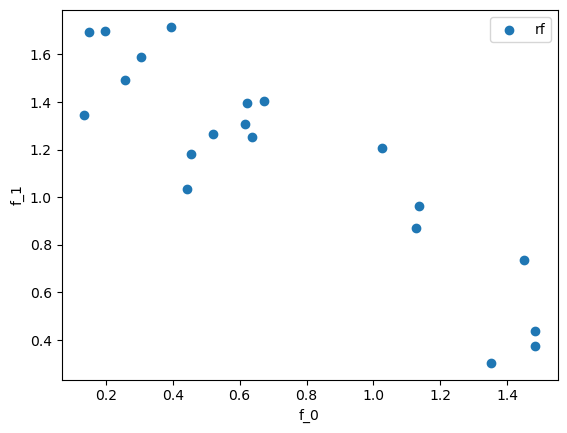

In [4]:

fig, ax = plt.subplots()

ax.scatter(recommender.experiments.f_0, recommender.experiments.f_1, label = "rf")

ax.legend()

ax.set_xlabel("f_0")
ax.set_ylabel("f_1")